###Carga de la librería necesaria

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from scipy.spatial.distance import cdist, mahalanobis
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import TruncatedSVD
from google.colab import drive

###Carga de los datos

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/medellin_clima_2_anios.csv'

df = pd.read_csv(file_path)

print(df.head())

Mounted at /content/drive
   codigo_x           fecha_hora  h_promedio     h_std   h_sum  t_promedio  \
0       197  2022-06-29 14:45:00   60.322667  0.593506  904.84   24.714667   
1       197  2022-06-29 15:00:00   59.664667  1.366768  894.97   24.759333   
2       197  2022-06-29 15:15:00   59.628000  0.709368  894.42   24.617333   
3       197  2022-06-29 15:30:00   59.266667  0.651050  889.00   24.583333   
4       197  2022-06-29 15:45:00   61.250000  0.883338  918.75   24.980000   

      t_std   t_sum  pr_promedio    pr_std  ...  p_sum  p_min  p_max  \
0  0.105076  370.72   842.491333  0.065232  ...    0.0    0.0    0.0   
1  0.070353  371.39   842.331333  0.040685  ...    0.0    0.0    0.0   
2  0.112787  369.26   842.247333  0.075068  ...    0.0    0.0    0.0   
3  0.106413  368.75   842.081333  0.064128  ...    0.0    0.0    0.0   
4  0.165357  374.70   841.872000  0.065049  ...    0.0    0.0    0.0   

   codigo_mapeado_2  codigo  nivel_metros_promedio  nivel_metros_std  \


###Selecciona las variables necesarias

In [ ]:
data = df[['p_sum', 'h_promedio', 't_promedio', 'vv_promedio']]
data

,p_sum,h_promedio,t_promedio,vv_promedio
0,0.0,60.322667,24.714667,1.749333
1,0.0,59.664667,24.759333,1.248667
2,0.0,59.628000,24.617333,1.646000
3,0.0,59.266667,24.583333,1.686667
4,0.0,61.250000,24.980000,0.842000
...,...,...,...,...
432475,0.0,71.722000,22.409333,2.108000
432476,0.0,67.688667,22.920667,1.637333
432477,0.0,64.669333,23.826667,1.223333
432478,0.0,62.563333,24.600000,1.182000


###Generar histograma de las variables

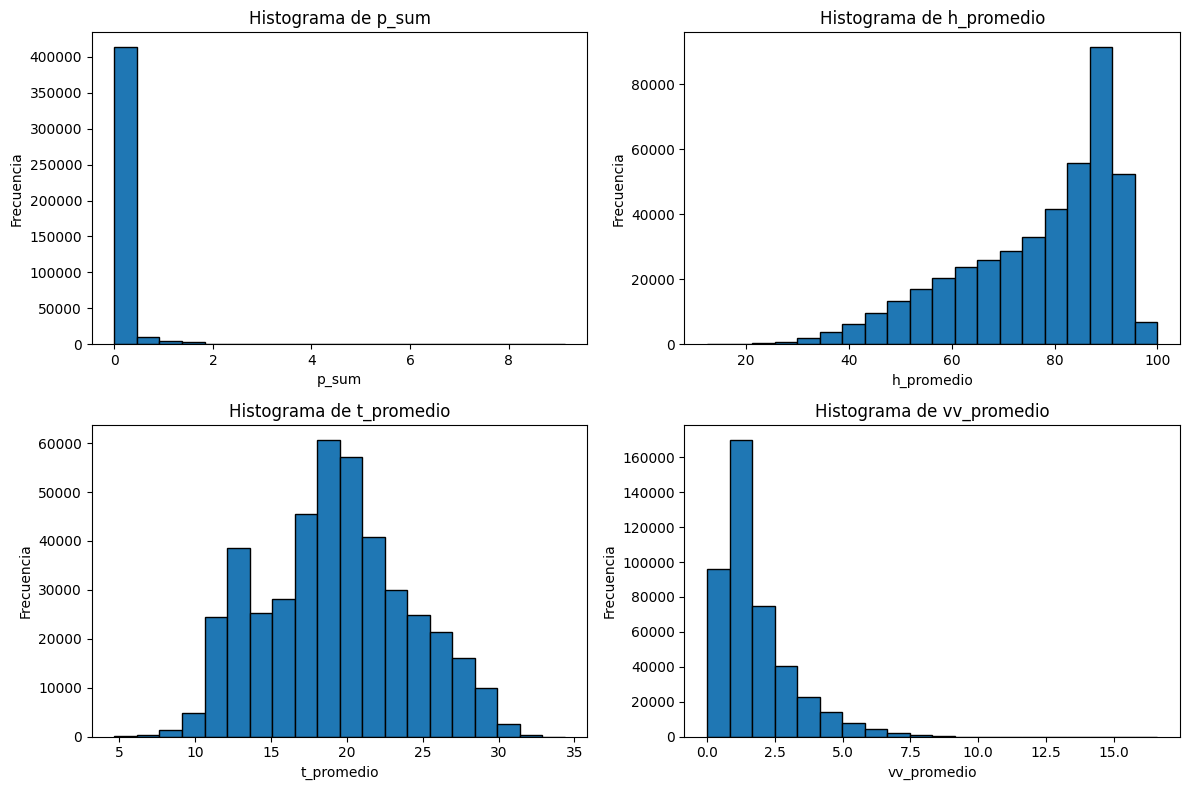

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, column in enumerate(data.columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.hist(data[column], bins=20, edgecolor='black')
    ax.set_title(f'Histograma de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

###Se calculan las métricas de distancias

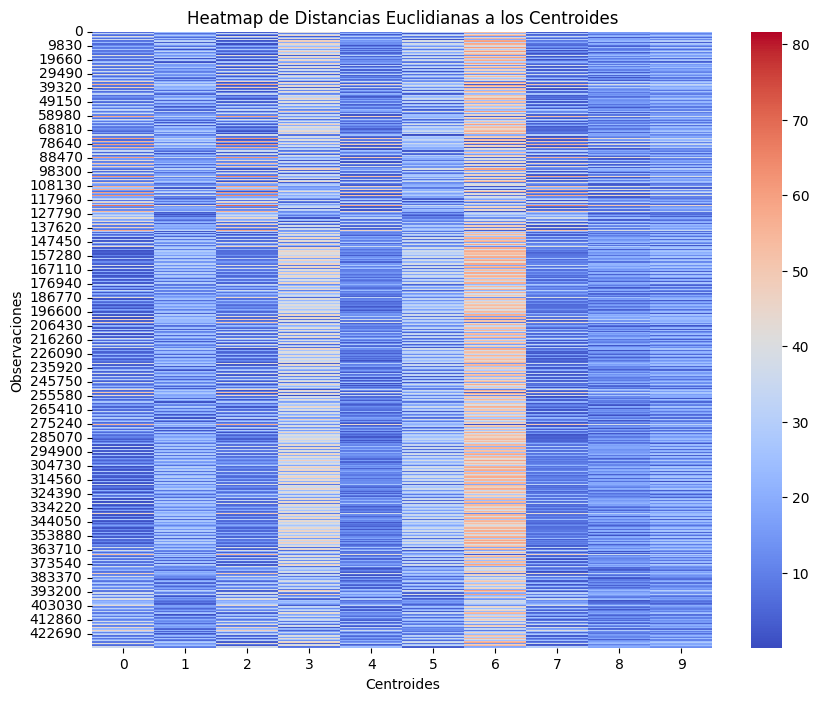

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(data)

dist_euclidean = cdist(data, kmeans.cluster_centers_, metric="euclidean")

plt.figure(figsize=(10, 8))
sns.heatmap(dist_euclidean, cmap="coolwarm", annot=False)
plt.title("Heatmap de Distancias Euclidianas a los Centroides")
plt.xlabel("Centroides")
plt.ylabel("Observaciones")
plt.show()


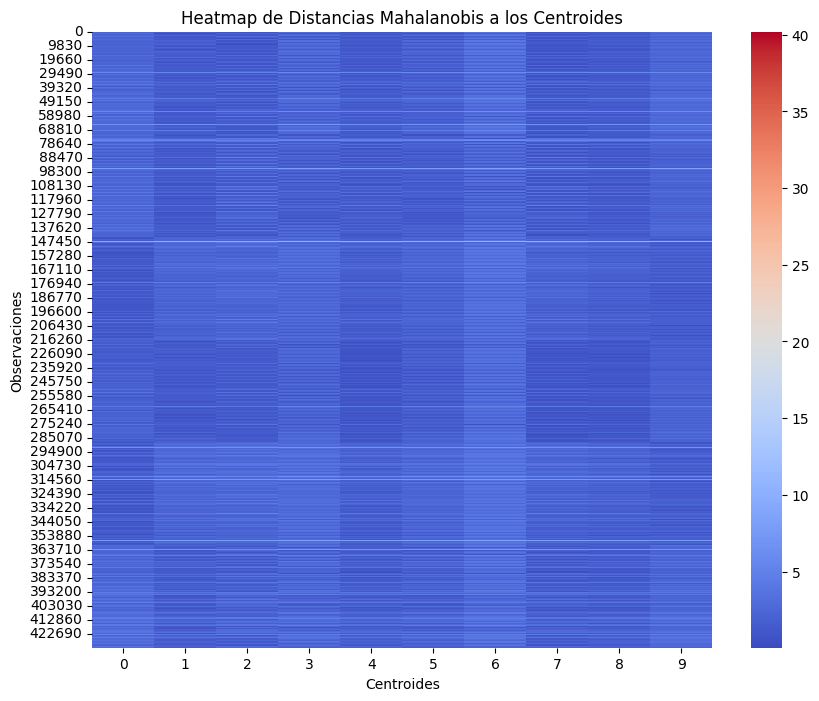

In [ ]:
cov_matrix = np.cov(data.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

dist_mahalanobis = np.array([
    [mahalanobis([obs[i] for i in range(len(obs))], centroid, inv_cov_matrix) for centroid in kmeans.cluster_centers_]
    for obs in data.itertuples(index=False)
])

plt.figure(figsize=(10, 8))
sns.heatmap(dist_mahalanobis, cmap="coolwarm", annot=False)
plt.title("Heatmap de Distancias Mahalanobis a los Centroides")
plt.xlabel("Centroides")
plt.ylabel("Observaciones")
plt.show()

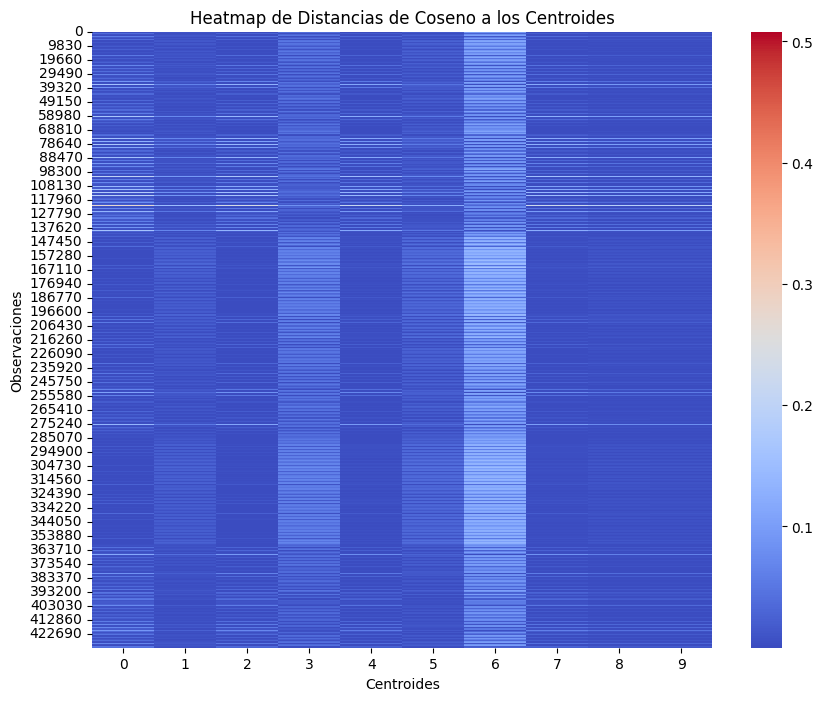

In [ ]:
dist_cosine = cdist(data, kmeans.cluster_centers_, metric="cosine")

plt.figure(figsize=(10, 8))
sns.heatmap(dist_cosine, cmap="coolwarm", annot=False)
plt.title("Heatmap de Distancias de Coseno a los Centroides")
plt.xlabel("Centroides")
plt.ylabel("Observaciones")
plt.show()


In [ ]:
distances = pd.DataFrame({
    'euclidean': dist_euclidean[:, 0],
    'mahalanobis': dist_mahalanobis[:, 0],
    'cosine': dist_cosine[:, 0]
})

filtered_indices = distances[
    (distances['euclidean'] <= np.percentile(distances['euclidean'], 95)) &
    (distances['mahalanobis'] <= np.percentile(distances['mahalanobis'], 95)) &
    (distances['cosine'] <= np.percentile(distances['cosine'], 95))
].index

data_filter = data.iloc[filtered_indices]

print(f"Datos originales: {data.shape[0]}, Datos finales: {data_filter.shape[0]}")

Datos originales: 432480, Datos finales: 393017


In [ ]:
data_filter

,p_sum,h_promedio,t_promedio,vv_promedio
0,0.0,60.322667,24.714667,1.749333
1,0.0,59.664667,24.759333,1.248667
2,0.0,59.628000,24.617333,1.646000
3,0.0,59.266667,24.583333,1.686667
4,0.0,61.250000,24.980000,0.842000
...,...,...,...,...
432475,0.0,71.722000,22.409333,2.108000
432476,0.0,67.688667,22.920667,1.637333
432477,0.0,64.669333,23.826667,1.223333
432478,0.0,62.563333,24.600000,1.182000


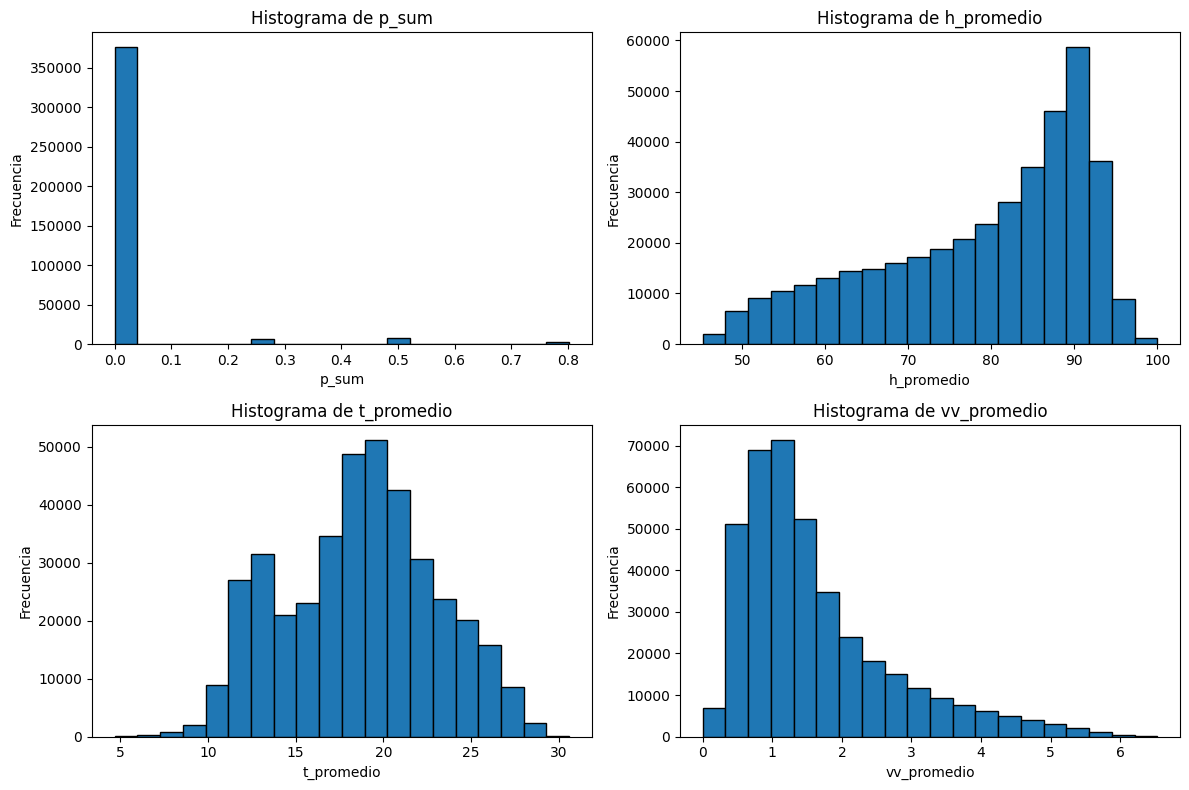

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, column in enumerate(data_filter.columns):
    if column in ['p_sum', 'h_promedio', 't_promedio', 'vv_promedio']:
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.hist(data_filter[column], bins=20, edgecolor='black')
        ax.set_title(f'Histograma de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

###Identificación y remoción de datos atípicos

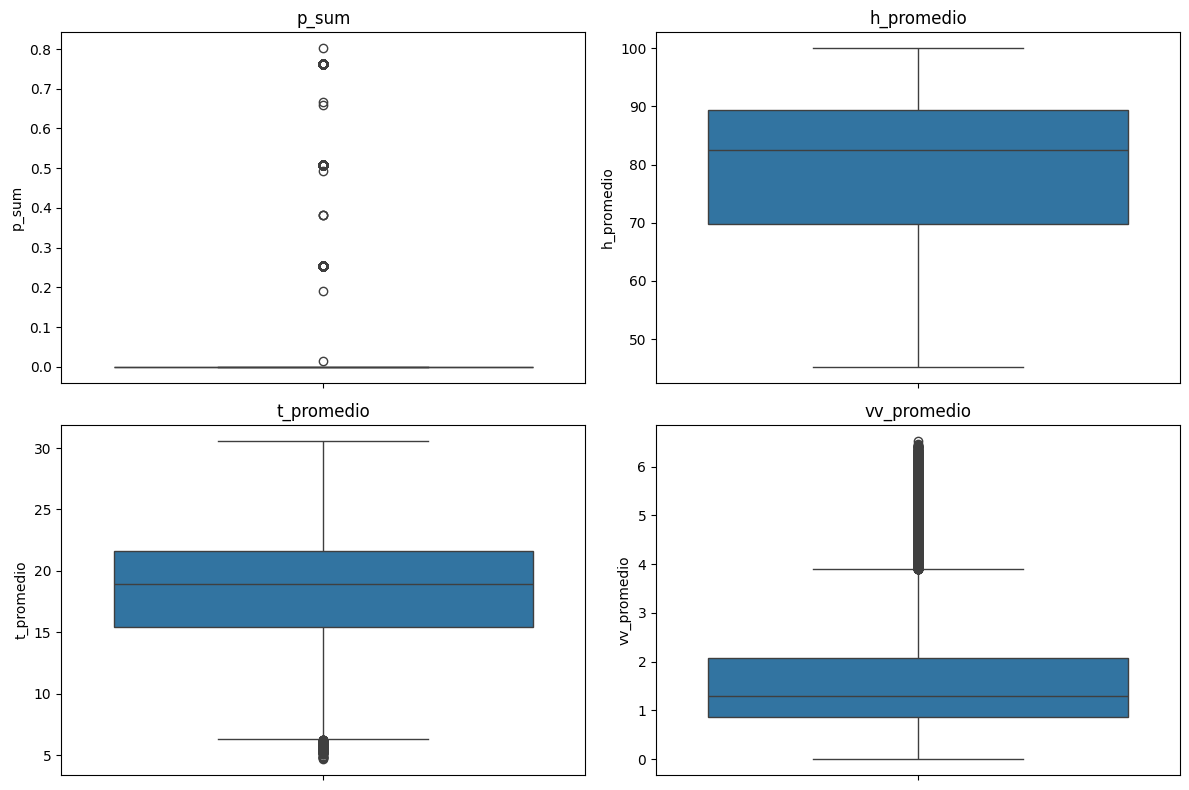

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(y=data_filter['p_sum'])
plt.title('p_sum')

plt.subplot(2, 2, 2)
sns.boxplot(y=data_filter['h_promedio'])
plt.title('h_promedio')

plt.subplot(2, 2, 3)
sns.boxplot(y=data_filter['t_promedio'])
plt.title('t_promedio')

plt.subplot(2, 2, 4)
sns.boxplot(y=data_filter['vv_promedio'])
plt.title('vv_promedio')

plt.tight_layout()
plt.show()

Datos finales después de eliminar outliers: 354973


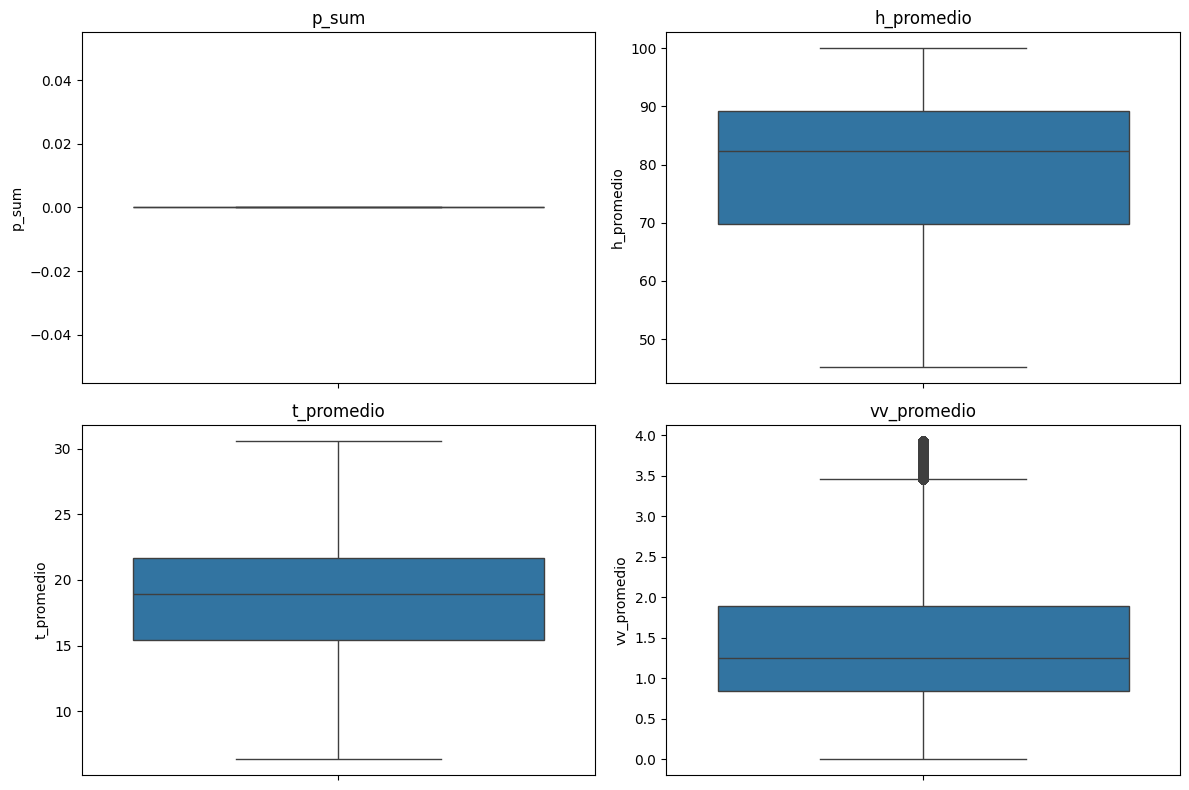

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

data_final = remove_outliers(data_filter, 'p_sum')
data_final = remove_outliers(data_final, 'h_promedio')
data_final = remove_outliers(data_final, 't_promedio')
data_final = remove_outliers(data_final, 'vv_promedio')

print(f"Datos finales después de eliminar outliers: {data_final.shape[0]}")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(y=data_final['p_sum'])
plt.title('p_sum')

plt.subplot(2, 2, 2)
sns.boxplot(y=data_final['h_promedio'])
plt.title('h_promedio')

plt.subplot(2, 2, 3)
sns.boxplot(y=data_final['t_promedio'])
plt.title('t_promedio')

plt.subplot(2, 2, 4)
sns.boxplot(y=data_final['vv_promedio'])
plt.title('vv_promedio')

plt.tight_layout()
plt.show()

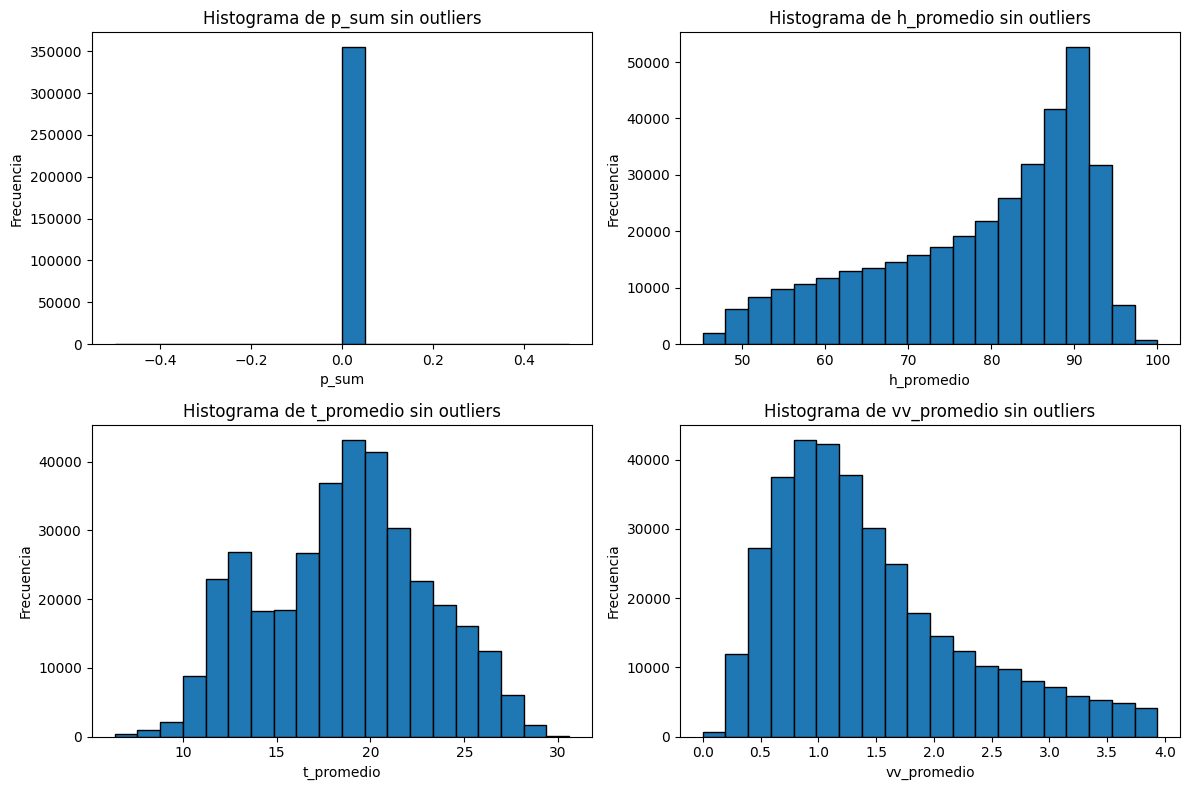

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, column in enumerate(data_final.columns):
    if column in ['p_sum', 'h_promedio', 't_promedio', 'vv_promedio']:
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.hist(data_final[column], bins=20, edgecolor='black')
        ax.set_title(f'Histograma de {column} sin outliers')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

###Calculos de valores y vectores propios

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
data_scaled

array([[-0.20079304, -1.09879201,  1.14990301, -0.01417376],
       [-0.20079304, -1.14249872,  1.15923766, -0.39942689],
       [-0.20079304, -1.14493425,  1.12956184, -0.09368673],
       ...,
       [-0.20079304, -0.81007086,  0.96432466, -0.41892039],
       [-0.20079304, -0.94995891,  1.12593944, -0.45072558],
       [-0.20079304, -0.93729415,  1.10796676, -0.12292698]])

In [ ]:
cov_matrix = np.cov(data_scaled, rowvar=False)
print("Matriz de covarianza:")
print(cov_matrix)


Matriz de covarianza:
[[ 1.00000231  0.16824429 -0.11471115 -0.05155006]
 [ 0.16824429  1.00000231 -0.76958931 -0.31135749]
 [-0.11471115 -0.76958931  1.00000231  0.27143784]
 [-0.05155006 -0.31135749  0.27143784  1.00000231]]


In [ ]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

print("Valores propios:")
print(eig_values)

print("\nVectores propios:")
print(eig_vectors)


Valores propios:
[1.9908779  0.22728341 0.96608609 0.81576186]

Vectores propios:
[[ 0.20223842  0.05067989  0.95705195 -0.20145159]
 [ 0.64406148 -0.7181459  -0.04335393  0.25994562]
 [-0.62917578 -0.69273322  0.09838638 -0.33849467]
 [-0.38525612 -0.04264623  0.26924363  0.88162741]]


In [ ]:
sorted_indices = np.argsort(eig_values)[::-1]
eig_values_sorted = eig_values[sorted_indices]
eig_vectors_sorted = eig_vectors[:, sorted_indices]

num_components = 4
eig_vectors_reduced = eig_vectors_sorted[:, :num_components]

print("Vectores propios seleccionados:")
print(eig_vectors_reduced)


Vectores propios seleccionados:
[[ 0.20223842  0.95705195 -0.20145159  0.05067989]
 [ 0.64406148 -0.04335393  0.25994562 -0.7181459 ]
 [-0.62917578  0.09838638 -0.33849467 -0.69273322]
 [-0.38525612  0.26924363  0.88162741 -0.04264623]]


In [ ]:
data_projected = np.dot(data_scaled, eig_vectors_reduced)

print("Datos proyectados:")
print(data_projected[:5])


Datos proyectados:
[[-1.46632826 -0.03521382 -0.64690811 -0.01705476]
 [-1.35193008 -0.13612751 -1.00107892  0.02429621]
 [-1.45261568 -0.05662303 -0.72211801  0.03356404]
 [-1.47565875 -0.04785634 -0.69836376  0.054388  ]
 [-1.19256807 -0.2204079  -1.26519633 -0.06992818]]


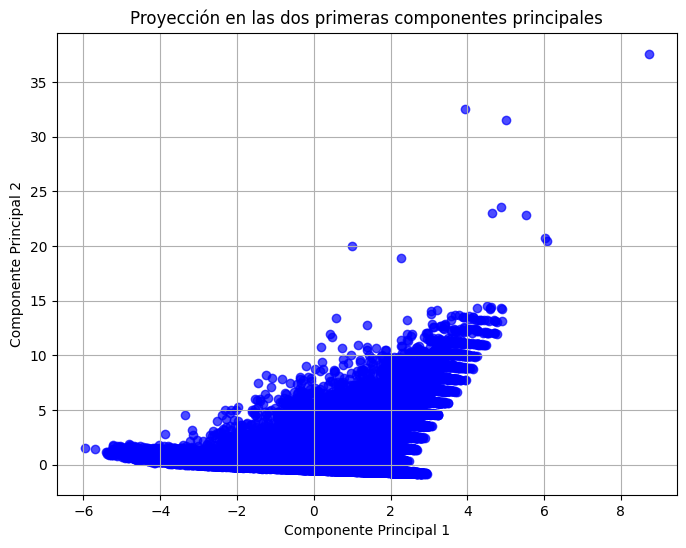

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c='blue', alpha=0.7)
plt.title("Proyección en las dos primeras componentes principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


In [ ]:
explained_variance_ratio = eig_values_sorted / np.sum(eig_values_sorted)
print("Proporción de varianza explicada por cada componente:")
print(explained_variance_ratio)


Proporción de varianza explicada por cada componente:
[0.49771832 0.24152096 0.20393999 0.05682072]


###Normas y determinantes para calcular varianzas globales

In [ ]:
frobenius_norm = np.linalg.norm(cov_matrix, 'fro')
print(f"Norma Frobenius: {frobenius_norm}")

spectral_norm = np.linalg.norm(cov_matrix, 2)
print(f"Norma 2 : {spectral_norm}")

det_cov = np.linalg.det(cov_matrix)
print(f"Determinante de la matriz de covarianza: {det_cov}")

trace_cov = np.trace(cov_matrix)
print(f"Traza de la matriz de covarianza (Varianza global): {trace_cov}")

Norma Frobenius: 2.369397032435001
Norma 2 : 1.9908779019224114
Determinante de la matriz de covarianza: 0.356608405444004
Traza de la matriz de covarianza (Varianza global): 4.000009249004004


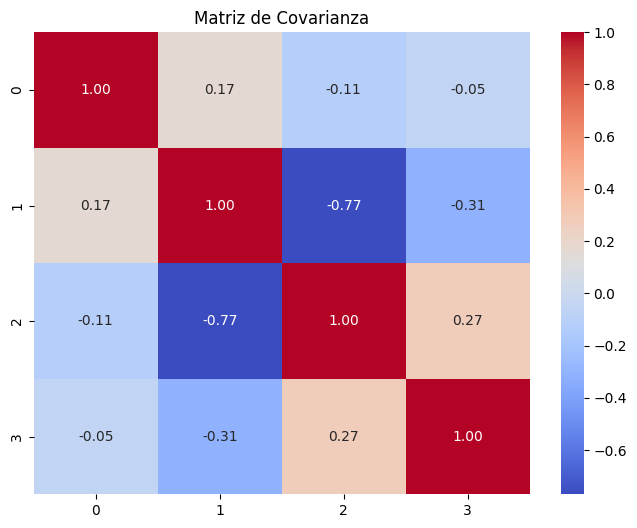

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Covarianza")
plt.show()


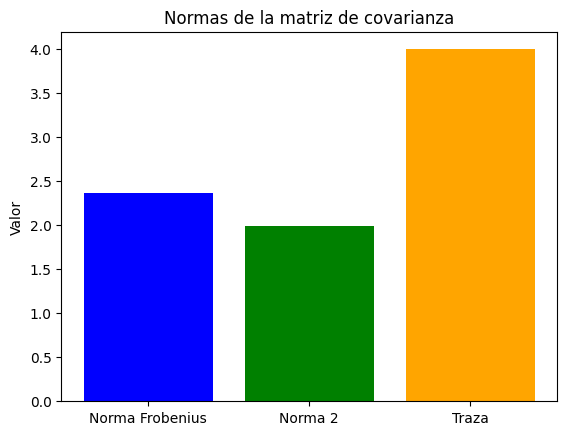

In [ ]:
norms = {"Norma Frobenius": frobenius_norm, "Norma 2": spectral_norm, "Traza": trace_cov}
plt.bar(norms.keys(), norms.values(), color=["blue", "green", "orange"])
plt.title("Normas de la matriz de covarianza")
plt.ylabel("Valor")
plt.show()


###Calculos de productos internos

Productos internos entre variables:
                     p_sum     h_promedio     t_promedio    vv_promedio
p_sum        432480.000000   72762.123879  -49610.161514  -22294.318208
h_promedio    72762.123879  432480.000000 -332831.216957 -134655.577926
t_promedio   -49610.161514 -332831.216957  432480.000000  117391.164778
vv_promedio  -22294.318208 -134655.577926  117391.164778  432480.000000


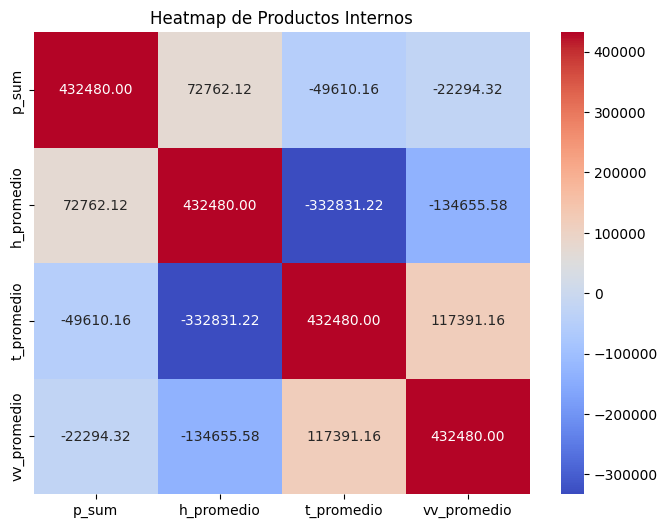

In [ ]:
data_normalized = (data_scaled - np.mean(data_scaled, axis=0)) / np.std(data_scaled, axis=0)

dot_products = np.dot(data_normalized.T, data_normalized)

variables = ['p_sum', 'h_promedio', 't_promedio', 'vv_promedio']
dot_product_df = pd.DataFrame(dot_products, index=variables, columns=variables)

print("Productos internos entre variables:")
print(dot_product_df)

plt.figure(figsize=(8, 6))
sns.heatmap(dot_product_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Productos Internos")
plt.show()

Similitud de coseno entre variables:
                p_sum  h_promedio  t_promedio  vv_promedio
p_sum        1.000000    0.168244   -0.114711    -0.051550
h_promedio   0.168244    1.000000   -0.769588    -0.311357
t_promedio  -0.114711   -0.769588    1.000000     0.271437
vv_promedio -0.051550   -0.311357    0.271437     1.000000


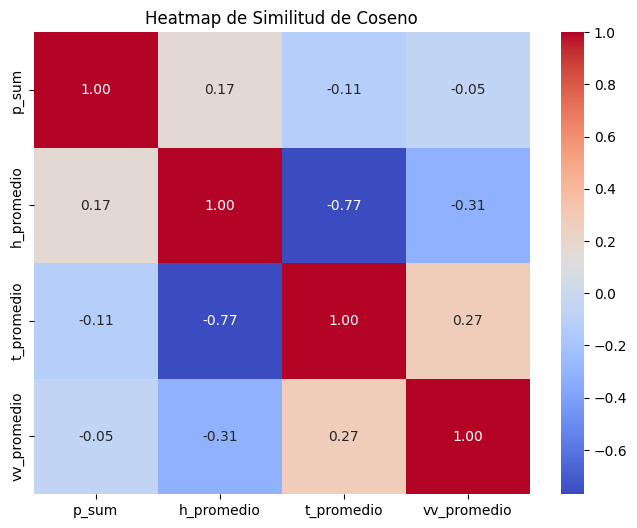

In [ ]:
cosine_sim = cosine_similarity(data_normalized.T)

cosine_sim_df = pd.DataFrame(cosine_sim, index=variables, columns=variables)

print("Similitud de coseno entre variables:")
print(cosine_sim_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Similitud de Coseno")
plt.show()

###Descompoicion en valores singulares

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

n_components = 4
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_result = svd.fit_transform(data_scaled)

print(f"Valores singulares (importancia de cada componente): \n{svd.singular_values_}")
print(f"Varianza explicada por cada componente: \n{svd.explained_variance_ratio_}")
print(f"Varianza total explicada: {sum(svd.explained_variance_ratio_)}")



Valores singulares (importancia de cada componente): 
[927.90779938 646.38374379 593.9695882  313.52081256]
Varianza explicada por cada componente: 
[0.49771832 0.24152096 0.20393999 0.05682072]
Varianza total explicada: 1.0000000000000058


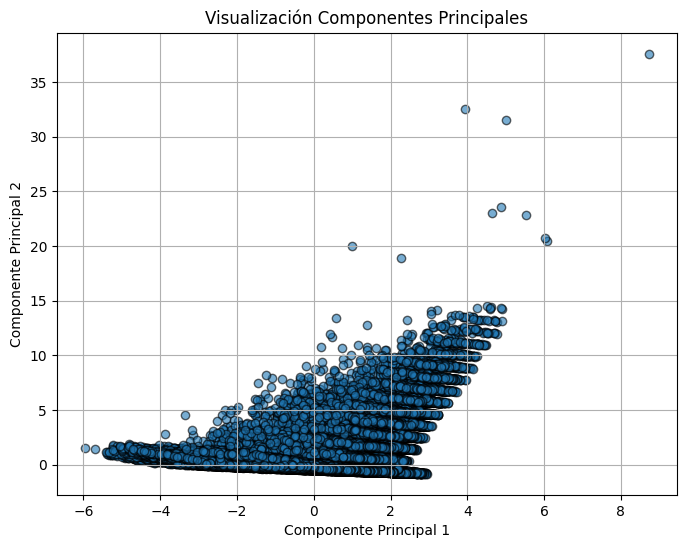

In [ ]:
import matplotlib.pyplot as plt

componentes_principales = pd.DataFrame(svd_result, columns=[f"PC{i+1}" for i in range(n_components)])

plt.figure(figsize=(8, 6))
plt.scatter(componentes_principales['PC1'], componentes_principales['PC2'], alpha=0.6, edgecolors='k')
plt.title("Visualización Componentes Principales")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()

###Número de condición de la matriz de covarianza

In [ ]:
eigenvalues = np.linalg.eigvals(cov_matrix)

cond_number = np.max(eigenvalues) / np.min(eigenvalues)

print(f"Número de condición de la matriz de covarianzas: {cond_number}")


Número de condición de la matriz de covarianzas: 8.7594512143004
